# Poisson Distribution



### Standard imports

First we import standard data manipulation libraries.

In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
from pathlib import Path

We also define globally accessible variables, such as the prediction length and the input path for the M5 data. Note that `single_prediction_length` corresponds to the length of the validation/evaluation periods, while `submission_prediction_length` corresponds to the length of both these periods combined.

By default the notebook is configured to run in submission mode (`submission` will be `True`), which means that we use all of the data for training and predict new values for a total length of `submission_prediction_length` for which we don't have ground truth values available (performance can be assessed by submitting prediction results to Kaggle). In contrast, setting `submission` to `False` will instead use the last `single_prediction_length`-many values of our training set as validation points (and hence these values will not be used for training), which enables us to validate our model's performance offline.

In [3]:
single_prediction_length = 28
submission_prediction_length = single_prediction_length * 2
m5_input_path="../../Data/m5-forecasting-accuracy"
submission=False

if submission:
    prediction_length = submission_prediction_length
else:
    prediction_length = single_prediction_length

### Reading the M5 data into GluonTS

First we need to convert the provided M5 data into a format that is readable by GluonTS. At this point we assume that the M5 data, which can be downloaded from Kaggle, is present under `m5_input_path`.

In [4]:
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
sales_train_validation = pd.read_csv(f'{m5_input_path}/sales_train_validation.csv')
sample_submission = pd.read_csv(f'{m5_input_path}/sample_submission.csv')
sell_prices = pd.read_csv(f'{m5_input_path}/sell_prices.csv')

In [5]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [6]:
print(calendar.shape,
sales_train_validation.shape,
sell_prices.shape)

(1969, 14) (30490, 1919) (6841121, 4)


We start the data convertion process by building dynamic features (features that change over time, just like the target values). Here, we are mainly interested in the event indicators `event_type_1` and `event_type_2`. We will mostly drop dynamic time features as GluonTS will automatically add some of these as part of many models' transformation chains.

In [7]:
cal_features = calendar.drop(
    ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'd'], 
    axis=1
)
cal_features['event_type_1'] = cal_features['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_features['event_type_2'] = cal_features['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)

test_cal_features = cal_features.values.T
if submission:
    train_cal_features = test_cal_features[:,:-submission_prediction_length]
else:
    train_cal_features = test_cal_features[:,:-submission_prediction_length-single_prediction_length]
    test_cal_features = test_cal_features[:,:-submission_prediction_length]

test_cal_features_list = [test_cal_features] * len(sales_train_validation)
train_cal_features_list = [train_cal_features] * len(sales_train_validation)

In [8]:
cal_features

,event_type_1,event_type_2,snap_CA,snap_TX,snap_WI
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,1,1,0
4,0,0,1,0,1
...,...,...,...,...,...
1964,0,0,0,1,1
1965,0,0,0,0,0
1966,0,0,0,0,0
1967,0,0,0,0,0


We then go on to build static features (features which are constant and series-specific). Here, we make use of all categorical features that are provided to us as part of the M5 data.

In [9]:
state_ids = sales_train_validation["state_id"].astype('category').cat.codes.values
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)

store_ids = sales_train_validation["store_id"].astype('category').cat.codes.values
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)

cat_ids = sales_train_validation["cat_id"].astype('category').cat.codes.values
cat_ids_un , cat_ids_counts = np.unique(cat_ids, return_counts=True)

dept_ids = sales_train_validation["dept_id"].astype('category').cat.codes.values
dept_ids_un , dept_ids_counts = np.unique(dept_ids, return_counts=True)

item_ids = sales_train_validation["item_id"].astype('category').cat.codes.values
item_ids_un , item_ids_counts = np.unique(item_ids, return_counts=True)

stat_cat_list = [item_ids, dept_ids, cat_ids, store_ids, state_ids]

stat_cat = np.concatenate(stat_cat_list)
stat_cat = stat_cat.reshape(len(stat_cat_list), len(item_ids)).T

stat_cat_cardinalities = [len(item_ids_un), len(dept_ids_un), len(cat_ids_un), len(store_ids_un), len(state_ids_un)]

Finally, we can build both the training and the testing set from target values and both static and dynamic features.

In [10]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

train_df = sales_train_validation.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
train_target_values = train_df.values

if submission == True:
    test_target_values = [np.append(ts, np.ones(submission_prediction_length) * np.nan) for ts in train_df.values]
else:
    test_target_values = train_target_values.copy()
    train_target_values = [ts[:-single_prediction_length] for ts in train_df.values]

m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(sales_train_validation))]

train_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(train_target_values,
                                         m5_dates,
                                         train_cal_features_list,
                                         stat_cat)
], freq="D")

test_ds = ListDataset([
    {
        FieldName.TARGET: target,
        FieldName.START: start,
        FieldName.FEAT_DYNAMIC_REAL: fdr,
        FieldName.FEAT_STATIC_CAT: fsc
    }
    for (target, start, fdr, fsc) in zip(test_target_values,
                                         m5_dates,
                                         test_cal_features_list,
                                         stat_cat)
], freq="D")

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/var/folders/gr/ff8nqlbn5yj2xyvj129ggsfh0000gp/T/ipykernel_68951/289369799.py:13: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  m5_dates = [pd.Timestamp("2011-01-29", freq='1D') for _ in range(len(sales_train_validation))]


In [11]:
len(train_target_values), len(m5_dates),len(train_cal_features_list),len(stat_cat)

(30490, 30490, 30490, 30490)

Just to be sure, we quickly verify that dataset format is correct and that our dataset does indeed contain the correct target values as well as dynamic and static features.

### Define the estimator

Having obtained our training and testing data, we can now create a GluonTS estimator. In our example we will use the `DeepAREstimator`, an autoregressive RNN which was developed primarily for the purpose of time series forecasting. Note however that you can use a variety of different estimators. Also, since GluonTS is mainly target at probabilistic time series forecasting, lots of different output distributions can be specified. In the M5 case, we think that the `NegativeBinomialOutput` distribution best describes the output.

For a full list of available estimators and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.html.

For a full list of available output distributions and possible initialization arguments see https://gluon-ts.mxnet.io/api/gluonts/gluonts.distribution.html.

In [12]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.poisson import PoissonOutput
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=prediction_length,
    freq="D",
    distr_output = PoissonOutput(),
    use_feat_dynamic_real=True,
    use_feat_static_cat=True,
    cardinality=stat_cat_cardinalities,
    trainer=Trainer(
        learning_rate=1e-3,
        epochs=100,
        num_batches_per_epoch=50,
        batch_size=32
    )
)

predictor = estimator.train(train_ds)

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/poulamisar

Early stopping based on learning rate scheduler callback (min_lr was reached).


### Generating forecasts

Once the estimator is fully trained, we can generate predictions from it for the test values.

In [13]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...


100%|██████████| 30490/30490 [00:15<00:00, 1909.33it/s]


Obtaining time series predictions ...


100%|██████████| 30490/30490 [27:07<00:00, 18.74it/s]


### Local performance validation (if `submission` is `False`)

Since we don't want to constantly submit our results to Kaggle, it is important to being able to evaluate performace on our own validation set offline. To do so, we create a custom evaluator which, in addition to GluonTS's standard performance metrics, also returns `MRMSSE` (corresponding to the mean RMSSE). Note that the official score for the M5 competition, the `WRMSSE`, is not yet computed. A future version of this notebook will replace the `MRMSSE` by the `WRMSSE`.

In [14]:

from gluonts.evaluation import  Evaluator
evaluator = Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
print(json.dumps(agg_metrics, indent=4))


Running evaluation: 100%|██████████| 30490/30490 [00:00<00:00, 61399.61it/s]
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/evaluation/_base.py:303: FutureWarning: Timestamp.fre

{
    "MSE": 4.57322716786969,
    "abs_error": 809100.0,
    "abs_target_sum": 1183626.0,
    "abs_target_mean": 1.3864334910743537,
    "seasonal_error": 0.9207256181588909,
    "MASE": 1.4345515416610677,
    "MAPE": 0.7345547589459525,
    "sMAPE": 1.4852983618460118,
    "MSIS": 15.255264795486907,
    "QuantileLoss[0.5]": 809100.0,
    "Coverage[0.5]": 0.20082579768542522,
    "QuantileLoss[0.67]": 845499.56,
    "Coverage[0.67]": 0.3424506864077258,
    "QuantileLoss[0.95]": 419027.10000000015,
    "Coverage[0.95]": 0.768702853394559,
    "QuantileLoss[0.99]": 217612.68000000005,
    "Coverage[0.99]": 0.8855573255869575,
    "RMSE": 2.1385105021649276,
    "NRMSE": 1.5424544458369842,
    "ND": 0.6835774138114573,
    "wQuantileLoss[0.5]": 0.6835774138114573,
    "wQuantileLoss[0.67]": 0.7143299995099804,
    "wQuantileLoss[0.95]": 0.3540198508650538,
    "wQuantileLoss[0.99]": 0.18385256829437682,
    "mean_absolute_QuantileLoss": 572809.8350000001,
    "mean_wQuantileLoss": 0.

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/pandas/core/construction.py:781: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


Plotting time series predictions ...


  0%|          | 0/5 [00:00<?, ?it/s]

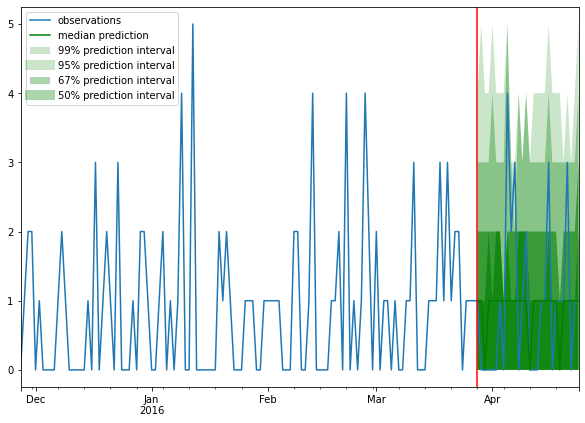

 20%|██        | 1/5 [00:00<00:02,  1.79it/s]

<Figure size 432x288 with 0 Axes>

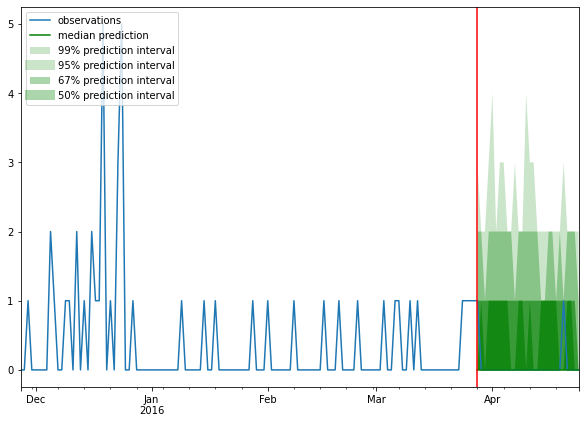

 40%|████      | 2/5 [00:00<00:01,  2.23it/s]

<Figure size 432x288 with 0 Axes>

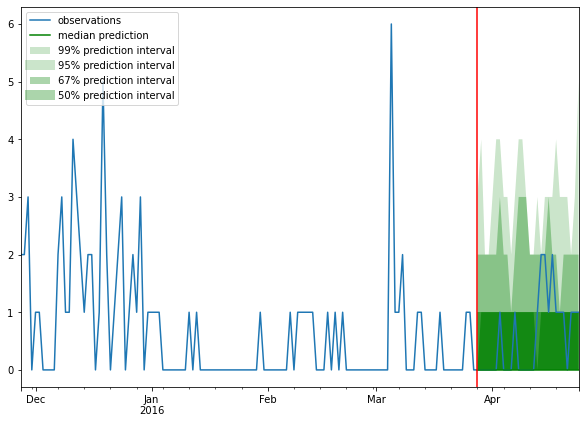

 60%|██████    | 3/5 [00:01<00:00,  2.52it/s]

<Figure size 432x288 with 0 Axes>

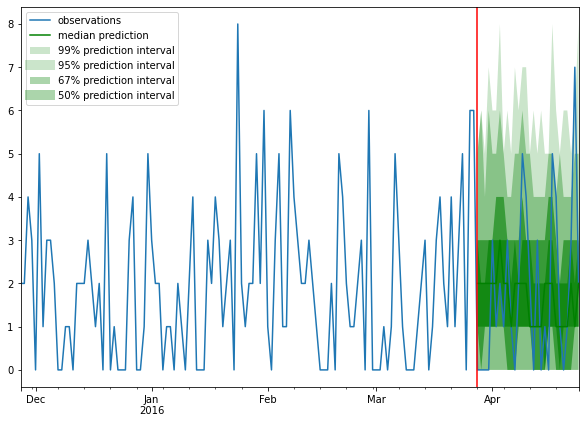

 80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

<Figure size 432x288 with 0 Axes>

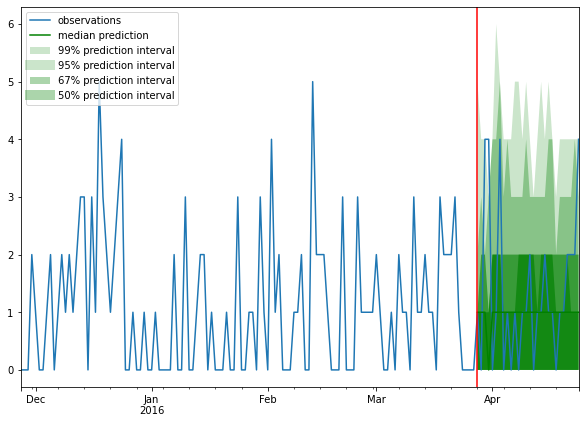

100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


<Figure size 432x288 with 0 Axes>

In [15]:
plot_log_path = "./plots/"
directory = os.path.dirname(plot_log_path)

if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-prediction_length], color='r')
    plt.legend(legend, loc="upper left")
    if inline:
        plt.show()
        plt.clf()
    else:
        plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))
        plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)

# ElectriCvity Dataset

In [19]:
from tqdm import tqdm

from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.repository.datasets import get_dataset
from functools import partial
from gluonts.mx.distribution.student_t import StudentTOutput

from gluonts.mx.distribution.poisson import PoissonOutput
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer


In [1]:
dataset = get_dataset(dataset_name="electricity")

NameError: name 'get_dataset' is not defined

In [19]:
estimator = DeepAREstimator(
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    distr_output = PoissonOutput(),
    trainer=Trainer(
        learning_rate=1e-3, epochs=50, num_batches_per_epoch=50
    ),
)

In [20]:
train_output = estimator.train(dataset.train)

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/poulamisar

In [21]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    #use_feat_dynamic_real=True,
    #use_feat_static_cat=True,
    predictor=train_output,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(dataset.test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(dataset.test)))

Obtaining time series conditioning values ...


100%|██████████| 414/414 [00:00<00:00, 1024.11it/s]


Obtaining time series predictions ...


100%|██████████| 414/414 [00:27<00:00, 15.09it/s]


In [22]:
from gluonts.evaluation import  Evaluator
evaluator = Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 1523.49it/s]
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-han

{
    "MSE": 13279536.864680873,
    "abs_error": 10180436.718823433,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 2.086873271614229,
    "MAPE": 0.13795862028948155,
    "sMAPE": 0.12887051570920607,
    "MSIS": 17.06635824202985,
    "QuantileLoss[0.5]": 10180436.853047848,
    "Coverage[0.5]": 0.3724838969404188,
    "QuantileLoss[0.67]": 10700230.485467758,
    "Coverage[0.67]": 0.49411231884057955,
    "QuantileLoss[0.95]": 5565872.471282386,
    "Coverage[0.95]": 0.8034420289855074,
    "QuantileLoss[0.99]": 2592379.041221619,
    "Coverage[0.99]": 0.8943739935587764,
    "RMSE": 3644.109886471712,
    "NRMSE": 0.4975014909649252,
    "ND": 0.06994034212046948,
    "wQuantileLoss[0.5]": 0.06994034304260101,
    "wQuantileLoss[0.67]": 0.07351136317538874,
    "wQuantileLoss[0.95]": 0.03823794947034282,
    "wQuantileLoss[0.99]": 0.017809832923349204,
    "mean_absolute_QuantileLoss": 725972

# M4 Dataset

In [20]:
dataset = get_dataset(dataset_name="m4_hourly")

In [21]:
estimator = DeepAREstimator(
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    distr_output = PoissonOutput(),
    trainer=Trainer(
        learning_rate=1e-3, epochs=50, num_batches_per_epoch=50
    ),
)

In [22]:
train_output = estimator.train(dataset.train)

/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users/poulamisar

In [23]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    #use_feat_dynamic_real=True,
    #use_feat_static_cat=True,
    predictor=train_output,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(dataset.test)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(dataset.test)))

Obtaining time series conditioning values ...


100%|██████████| 414/414 [00:00<00:00, 1271.94it/s]


Obtaining time series predictions ...


100%|██████████| 414/414 [00:28<00:00, 14.46it/s]


In [24]:
### M4_hourly
from gluonts.evaluation import  Evaluator
evaluator = Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 1233.02it/s]
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/poulamisarkar/opt/anaconda3/envs/forcasting/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-han

{
    "MSE": 83864430.26278143,
    "abs_error": 23974909.60022354,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 6.424244470813012,
    "MAPE": 0.39878369699833655,
    "sMAPE": 0.24835508265165127,
    "MSIS": 99.75845126015463,
    "QuantileLoss[0.5]": 23974909.60021019,
    "Coverage[0.5]": 0.5785527375201285,
    "QuantileLoss[0.67]": 30345307.764072645,
    "Coverage[0.67]": 0.6821155394524964,
    "QuantileLoss[0.95]": 40049672.64000654,
    "Coverage[0.95]": 0.7335950080515293,
    "QuantileLoss[0.99]": 41050262.24800102,
    "Coverage[0.99]": 0.7496477455716594,
    "RMSE": 9157.752467870128,
    "NRMSE": 1.2502354892114143,
    "ND": 0.1647093760375296,
    "wQuantileLoss[0.5]": 0.16470937603743788,
    "wQuantileLoss[0.67]": 0.20847447564267793,
    "wQuantileLoss[0.95]": 0.27514416951049914,
    "wQuantileLoss[0.99]": 0.28201829303173526,
    "mean_absolute_QuantileLoss": 33855038.063